# Example: Review Labeling by Topic

In this notebook, we will use a subset of the Amazon Product Review data to demonstrate the usage of this work for labeling arguments. The problem to be addressed here is determining the credibility (reliable/unreliable) of reviews that evaluate a specific aspect of the product (i.e. size of shoes) and being able to provide reasoning for the results. The dataset can be found [here](https://github.com/EyeofBeholder-NLeSC/orange3-argument/blob/doc/examples/example_dataset.json).

In [21]:
from orangearg.argument.miner import reader, chunker, processor, miner

fpath = "./example_dataset.json"

### Read the input file

In [2]:
df_arguments = reader.read_json_file(fpath=fpath)
df_arguments = df_arguments.dropna().reset_index(drop=True)  # remove rows with na

The results of reading the data file are as follows. It can be seen that this dataset contains two aspects of information, namely the text of the reviews (`reviewText`) and the rating evaluations provided by the purchasers (`overall`, ranging from 1 to 5 stars).

In [3]:
df_arguments

,reviewText,overall
0,I always get a half size up in my tennis shoes...,3
1,Put them on and walked 3 hours with no problem...,5
2,excelente,5
3,The shoes fit well in the arch area. They are ...,4
4,Tried them on in a store before buying online ...,5
...,...,...
365,Favorite Nike shoe ever! The flex sole is exce...,5
366,"I wear these everyday to work, the gym, etc.",5
367,"Love these shoes! Great fit, very light weight.",5
368,Super comfortable and fit my small feet perfec...,5


### Split arguments into chunks

By analyzing, reviews will first be segmented into smaller chunks, which are clauses that express complete meanings. The reason for doing this is to identify from which different perspectives reviews provide their evaluations, in preparation for the subsequent review labeling process. 

In [4]:
arguments = df_arguments["reviewText"]
arg_scores = df_arguments["overall"]

# Split reviews into chunks
chunk_arg_ids, chunks = chunker.get_chunk(docs=arguments)

# Compute polarity score of chunks
chunk_p_scores = chunker.get_chunk_polarity_score(chunks=chunks)

# Compute topics of chunks
chunk_topics, chunk_embeds, df_topics = chunker.get_chunk_topic(chunks=chunks)

# Comput importance of chunks inside the arguments
chunk_ranks = chunker.get_chunk_rank(arg_ids=chunk_arg_ids, embeds=chunk_embeds)

# Collect everything together as a dataframe
df_chunks = chunker.get_chunk_table(
    arg_ids=chunk_arg_ids, 
    chunks=chunks, 
    p_scores=chunk_p_scores, 
    topics=chunk_topics, 
    ranks=chunk_ranks
)

Some explanations of `df_chunks`:

* `argument_id`: the index of the argument the chunk coming from.

* `polarity_score`: the sentiment polarity score of a chunk, in range of [-1, 1], where 0 signifies neutrality, positive values indicate positivity, and negative values denote negativity. 

* `topic`: the index of a topic in the `df_topics` table below.

* `rank`: importance of a chunk within the argument it comes from, in range of [0, 1]. This is computed as the pagerank of chunks based on the similarity network of chunks. Therefore, the sum of ranks from chunks belonging to the same argument is equal to 1.

In [5]:
df_chunks

,argument_id,chunk,polarity_score,topic,rank
0,0,I always get a half size up in my tennis shoes .,-0.166667,4,0.500000
1,0,For some reason these feel to big in the heel ...,-0.050000,10,0.500000
2,1,walked 3 hours with no problem,0.000000,7,0.249374
3,1,Put them on and !,0.000000,2,0.255228
4,1,Love them !,0.625000,3,0.250344
...,...,...,...,...,...
1192,368,I can wear the shoe all day long and,-0.050000,15,0.125961
1193,368,they are easy to clean compared to other shoes...,0.225000,0,0.128238
1194,368,They are light colored so any dirt will be see...,0.342857,23,0.128449
1195,368,Would definitely buy another pair in a differe...,0.000000,13,0.125681


And explanations of `df_topics`:

* `topic`: the index of a topic

* `count`: the number of chunks in a topic

* `keywords`: the top keywords of a topic

* `name`: a short name of the topic

In [6]:
df_topics.head()

,topic,count,name,keywords
0,0,147,0_shoes_the_these_for,"(shoes, the, these, for, shoe, comfortable, ar..."
1,1,99,1_fit_perfect_true_perfectly,"(fit, perfect, true, perfectly, fits, expected..."
2,2,87,2_for_them_work_use,"(for, them, work, use, wear, training, in, gym..."
3,3,79,3_love_them_they_are,"(love, them, they, are, these, cute, really, p..."
4,4,74,4_size_ordered_half_big,"(size, ordered, half, big, large, order, an, a..."


### Merge chunks back to arguments

By merging the chunks back into reviews and performing the corresponding computations, we will obtain relevant information at the review level, including the topics covered in each review, the sentiment of the review, and its consistency with the overall score. This information will be further used for labeling reviews under different topics.

In [7]:
# Compute topics of arguments
arg_topics = processor.get_argument_topics(arg_ids=chunk_arg_ids, topics=chunk_topics)

# Compute sentiment of arguments
arg_sentiments = processor.get_argument_sentiment(arg_ids=chunk_arg_ids, ranks=chunk_ranks, p_scores=chunk_p_scores)

# Compute the coherence between the sentiments and the overall of arguments
arg_coherences = processor.get_argument_coherence(scores=arg_scores, sentiments=arg_sentiments)

# Collect everything together as a datafrae
df_arguments_processed = processor.update_argument_table(
    df_arguments=df_arguments, 
    topics=arg_topics, 
    sentiments=arg_sentiments, 
    coherences=arg_coherences
)

Some columns are added to the original `df_arguments` dataframe, which are:

* `topics`: the topics that an argument has mentioned.

* `sentiment`: the sentiment score of an argument, in range of [0, 1], the higher the more positive.

* `coherence`: the coherence between the `sentiment` and `overall`, in range of [0, 1], the higher the more coherent.

In [8]:
df_arguments_processed.head()

,reviewText,overall,topics,sentiment,coherence
0,I always get a half size up in my tennis shoes...,3,"(4, 10)",0.445833,0.992692
1,Put them on and walked 3 hours with no problem...,5,"(7, 2, 3, 9)",0.627243,0.706545
2,excelente,5,"(6,)",0.500000,0.535261
3,The shoes fit well in the arch area. They are ...,4,"(0, 10, 10, 21)",0.524397,0.880521
4,Tried them on in a store before buying online ...,5,"(1, 0, 5, 0, 6)",0.712758,0.813614


### Review labeling

In this step, by looking at reviews under a specific topic, an attacking network of reviews are built, where nodes are reviews and edges are the attacks in between. Reviews are labeled based on that. 

These are the rules of generating the network:

* Edges exist only between reviews with different `overall`.

* Edges start from a review with higher coherence to lower coherence.

* Weight of edges are computed as difference of coherence of the vertices.

* A node is labeled as `supportive` (meaning reliable in our case),

    * if no other nodes attack it, or

    * if all attackers of this node are attacked by some other nodes.

* A node is labeled as `defeated` (meaning unreliable in our case), if it is not `supportive`.  

In [9]:
from IPython.display import display, HTML

# Select reviews of the last topic
last_topic = df_topics.iloc[-1]["topic"]
print(f"The last topic is topic nr. {last_topic}:")
display(HTML(df_topics[df_topics["topic"] == last_topic].to_html()))

The last topic is topic nr. 24:


,topic,count,name,keywords
24,24,19,24_return_returned_returning_ca,"(return, returned, returning, ca, because, them, can, were, defective, package)"


Seems that the arguments under this topic are about judgements of the returning experience of this product.

In [10]:
# select the arguments under the last topic
arg_selection = miner.select_by_topic(data=df_arguments_processed, topic=last_topic)
arg_selection = arg_selection.rename(columns={
    "reviewText": "argument", 
    "overall": "score"
})  # rename columns for the following steps
arg_selection

,argument,score,topics,sentiment,coherence,argument_id
0,"I wore these shoe one time, from the airport i...",1,"(16, 14, 23, 24, 24)",0.500000,0.535261,46
1,I usually wear a size 8 and they fit fine. The...,1,"(1, 4, 10, 24, 4, 6)",0.496439,0.540030,77
2,"Great shoe! Outside arch is kind of high, but ...",5,"(21, 2, 19, 14, 4, 4, 4, 1, 24)",0.659098,0.747863,78
3,I bought these for gym training - weight class...,2,"(13, 2, 7, 7, 18, 7, 24, 10)",0.516497,0.837317,83
4,Oops! I returned these because I ordered wrong...,1,"(14, 24)",0.343750,0.744226,114
5,I loved these shoes...that is until after abou...,1,"(13, 7, 24)",0.599393,0.407310,118
6,I returned them...found a Ryka pair I liked be...,3,"(24,)",0.775000,0.827735,121
7,I got the impression it's cushiony and comfy b...,3,"(0, 2, 24, 11, 9, 18, 6, 24)",0.565749,0.989251,154
8,Ordered 9(m) received 9 Wide for the second ti...,1,"(4, 4, 24)",0.491652,0.546454,205
9,Returning these. the pictures on here make the...,1,"(24, 23, 23, 23, 3, 15)",0.520525,0.507953,254


In [11]:
# Compute edges of the attacking network
edges = miner.get_edges(data=arg_selection)
weights = miner.get_edge_weights(data=arg_selection, edges=edges)
df_edges = miner.get_edge_table(edges=edges, weights=weights)


Edges are defined between reviews with different overall scores. Also, edges are directed and weighted, where `source` and `target` are indices of reviews in `arg_selection`.

In [12]:
df_edges

,source,target,weight
0,2,0,0.21
1,3,0,0.30
2,6,0,0.29
3,7,0,0.45
4,10,0,0.25
...,...,...,...
66,12,11,0.15
67,11,13,0.30
68,11,14,0.10
69,12,13,0.45


In [13]:
# Compute labels of reviews in the selection
labels = miner.get_node_labels(
    indices=arg_selection.index.tolist(), 
    sources=df_edges["source"].tolist(), 
    targets=df_edges["target"].tolist()
)
arg_selection["labels"] = labels
arg_selection

,argument,score,topics,sentiment,coherence,argument_id,labels
0,"I wore these shoe one time, from the airport i...",1,"(16, 14, 23, 24, 24)",0.500000,0.535261,46,defeated
1,I usually wear a size 8 and they fit fine. The...,1,"(1, 4, 10, 24, 4, 6)",0.496439,0.540030,77,defeated
2,"Great shoe! Outside arch is kind of high, but ...",5,"(21, 2, 19, 14, 4, 4, 4, 1, 24)",0.659098,0.747863,78,defeated
3,I bought these for gym training - weight class...,2,"(13, 2, 7, 7, 18, 7, 24, 10)",0.516497,0.837317,83,defeated
4,Oops! I returned these because I ordered wrong...,1,"(14, 24)",0.343750,0.744226,114,defeated
5,I loved these shoes...that is until after abou...,1,"(13, 7, 24)",0.599393,0.407310,118,defeated
6,I returned them...found a Ryka pair I liked be...,3,"(24,)",0.775000,0.827735,121,supportive
7,I got the impression it's cushiony and comfy b...,3,"(0, 2, 24, 11, 9, 18, 6, 24)",0.565749,0.989251,154,supportive
8,Ordered 9(m) received 9 Wide for the second ti...,1,"(4, 4, 24)",0.491652,0.546454,205,defeated
9,Returning these. the pictures on here make the...,1,"(24, 23, 23, 23, 3, 15)",0.520525,0.507953,254,defeated


The attacking network of the reviews are visualized as below for better understanding the output.

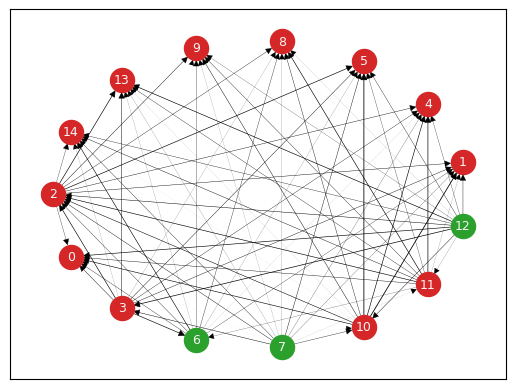

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

DG = nx.DiGraph()
DG.add_edges_from(edges)

# graph layout
pos = nx.shell_layout(DG)

# draw nodes
reliable_indices = arg_selection[arg_selection["labels"] == "supportive"].index.tolist()
unreliable_indices = arg_selection[arg_selection["labels"] == "defeated"].index.tolist()
nx.draw_networkx_nodes(DG, pos, nodelist=reliable_indices, node_color="tab:green")
nx.draw_networkx_nodes(DG, pos, nodelist=unreliable_indices, node_color="tab:red")

# draw edges
nx.draw_networkx_edges(DG, pos, width=df_edges["weight"])

# draw labels
labels = {i: i for i in arg_selection.index}
nx.draw_networkx_labels(DG, pos, labels, font_size=9, font_color="whitesmoke")

plt.show()

It can be seen from the above plot that review #6, #7, and #12 are considered reliable, while the others are not. Look back to the `arg_selection` table, it seems that those reviews indeed show very high level of consistence, except #6, which is attacked by #3 and #11. But since they are also attacked by some other reviews, #6 is safe. 

The weights of edges seems to make sense. One example here is that the attack $11\rightarrow6$ is much weaker than $3\rightarrow6$, because #3 describes the totally opposite returning experience than #6 and #11 (can't return in #3 vs. return succesfully in $6 and #11).